# Imports and Settings

In [243]:
%load_ext autoreload
%autoreload 2

from datetime import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math
import numba as nb
from LineDetection import LineDetection as LD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
N_FREQUENCY_CHANNELS = 64 # Must be power of 2
N_TIME_SAMPLES = 128 # Must be >= N_FREQUENCY_CHANNELS

# Upper bound of the FRB
UPPER_BOUND = int(np.random.random()*N_FREQUENCY_CHANNELS)

# Lower bound of the FRB
LOWER_BOUND = int(np.random.random()*UPPER_BOUND)

UPPER_BOUND = 3*N_FREQUENCY_CHANNELS//4
LOWER_BOUND = 1*N_FREQUENCY_CHANNELS//4

# RFI intensitiy will be in range [0, RFI_STRENGTH)
RFI_STRENGTH = 1

# FRB intensity will be in range [FRB_MIN_STRENGTH, FRB_MAX_STRENGTH)
FRB_MAX_STRENGTH = 2
FRB_MIN_STRENGTH = 2

# Experimental

EMPHASIZE = True
LOW_FILTER = False

LOW_FILTER_MAX = 2

# Create Data
## Create the data with the background noise

In [245]:
data = np.random.random( (N_FREQUENCY_CHANNELS, N_TIME_SAMPLES) )*RFI_STRENGTH+1

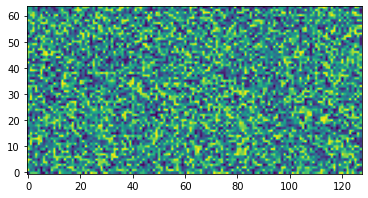

In [246]:
plt.imshow(data, origin="lower")
plt.show()

## Draw a line in the data

In [247]:
# Draws a line in the data given the lines slope and y incercept
def draw_line(data, m, X):
    for y in range(LOWER_BOUND, UPPER_BOUND):
        data[int(y)][int(m*y+X)] = np.random.random()*( FRB_MAX_STRENGTH-FRB_MIN_STRENGTH ) + FRB_MIN_STRENGTH
    
    return data
    

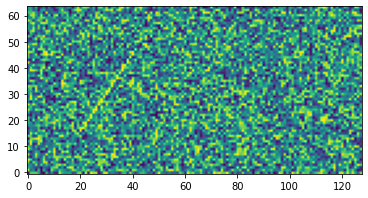

In [248]:
m = math.tan(np.random.random()*math.pi/4 + math.pi/4) # Choose a ranom slope in range [PI/4, PI/2)
x_intercept = np.random.random()*N_TIME_SAMPLES # Choose a random x intercept in range [0, N_SAMPLES)

data = draw_line(data, 1/m, x_intercept) # Draw the line

plt.imshow(data, origin="lower")
plt.show()

# FRB Detection

In [249]:
@nb.jit(nopython=True, parallel=True)
def filter(data):
    n =  ( N_FREQUENCY_CHANNELS*FRB_MAX_STRENGTH )**7

    for x in range( N_TIME_SAMPLES ):
        for y in range( N_FREQUENCY_CHANNELS ):
            if LOW_FILTER and data[y][x] <= LOW_FILTER_MAX:
                data[y][x] = 0
            elif EMPHASIZE:
                data[y][x] = data[y][x]**10 / n
    
    return data

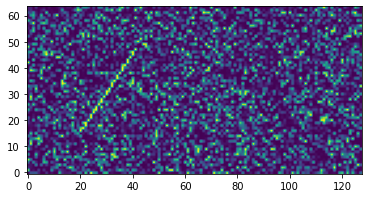

In [250]:
data = filter(data)
plt.imshow(data, origin="lower")
plt.show()

In [251]:
def line_detection_slosar(data):
    todo = [data]
    while todo[0].shape[0]>1:
        outdo = []
        for subar in todo:
            Nf, Nt = subar.shape
            assert(Nf%2 == 0)
            Nfhalf = Nf //2
            vert = np.array([subar[2*i,:]+subar[2*i+1,:] for i in range(Nfhalf)])
            diag = np.array([subar[2*i,i:-Nfhalf+i-1]+subar[2*i+1,i+1:-Nfhalf+i] for i in range(Nfhalf)])
            outdo.append(vert)
            outdo.append(diag)
        todo = outdo
    outar = np.zeros_like(data)
    Nf = data.shape[0]
    for i,line in enumerate(outdo):
        outar[i,:line.shape[1]] = line[0,:]
    return outar
    
def line_detection_brandon(data, i):
    Nc = 2**i # Number Of Channels
    Ch = N_TIME_SAMPLES//Nc # Channel Height

    if Ch > 1:
        Cw = data.shape[1] # Channel Width
        f = lambda i: data[2*i,i:-Ch//2+i-1] + data[2*i+1,i+1:-Ch//2+i]

        vert = line_detection_brandon(data[0:Ch:2] + data[1:Ch+1:2], i+1)
        diag = line_detection_brandon(np.array([ f(i) for i in range(Ch//2) ]), i+1)

        data[0:Ch//2, :] = vert
        data[Ch//2:Ch, 0:diag.shape[1]] = diag
        data[Ch//2:Ch, diag.shape[1]:Cw] = 0

    return data



In [252]:
# start = dt.now()
# res = line_detection_slosar(data)
# plt.imshow(res, origin="lower")
# plt.show()
# end = dt.now()

# print("Mr. Slosars Function Takes: ", end - start)

# start = dt.now()
# res = line_detection_brandon(data, 0)
# plt.imshow(res, origin="lower")
# plt.show()
# end = dt.now()

# print("Brandons Function takes: ", end - start)




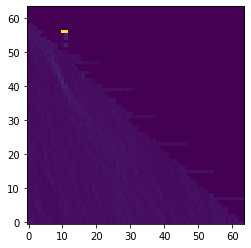

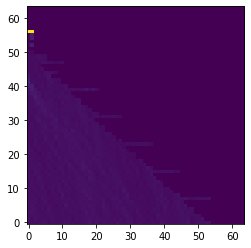

In [253]:
detector = LD(64)

A = data[0:N_FREQUENCY_CHANNELS, 0:N_FREQUENCY_CHANNELS]
B = data[0:N_FREQUENCY_CHANNELS, 10:N_FREQUENCY_CHANNELS+10]

resA = detector.Detect(A)
resB = detector.Detect(B, 10)

plt.imshow(resA, origin="lower")
plt.show()
plt.imshow(resB, origin="lower")
plt.show()